In [ ]:
# Fall 2024 - MH
# Environment: fmri_stats
# Organize and plot LMER results for delta RSA neural score predicting quiz scores

In [33]:
# SET-UP
import numpy as np
import pandas as pd
import scipy.stats as st
import copy
import pickle
import matplotlib.pyplot as plt

from pymer4.models import Lmer

base_dir = '/dartfs-hpc/rc/lab/K/KraemerD/ASL1-2_combined/'
rsa_dir=base_dir+'data/rsa/'
lmer_dir = base_dir+'data/lmer_summary_scores/'

n_parcs = 500 # parcellation resolution

# read in behavioral quiz scores
beh = pd.read_csv(base_dir+'data/behavioral/ASL2_summary_quiz_scores_all.csv')

# significant parcels determined by parcel-selection RSA:
eng_parcs = [1, 4, 7, 19, 23, 26, 27, 32, 33, 34, 59, 60, 63, 64, 66, 67, 70, 72, 78, 87, 88, 92, 93, 94, 97, 102, 104, 114,
             118, 119, 122, 124, 126, 129, 132, 135, 137, 139, 144, 156, 159, 162, 164, 168, 170, 177, 178, 181, 198, 201, 202,
             207, 208, 209, 212, 215, 219, 227, 228, 229, 230, 233, 248, 249, 264, 272, 277, 279, 280, 301, 311, 314, 317, 326,
             339, 342, 350, 352, 356, 358, 359, 363, 368, 370, 375, 381, 386, 398, 399, 407, 414, 417, 425, 434, 445, 447, 455,
             472, 473, 474, 475, 487]

asl_parcs = [31, 47, 72, 106, 147, 200, 230, 238, 291, 304, 358, 362, 367, 382, 412, 436, 455, 457, 490]

union = list(np.unique(eng_parcs+asl_parcs))
overlap = [ x for x in eng_parcs if x in asl_parcs ]

In [ ]:
# First, compute delta neural scores from word2vec_weighted RSA results

In [3]:
# read in all asl rsa scores
m = 'word2vec_weighted'

known1_fn = rsa_dir+'corrs/'+m+'_grp1_asl2_words1_Schaefer500_corrs_normed.pkl'
known1 = pickle.load(open(known1_fn,'rb'),encoding='latin1')

known2_fn = rsa_dir+'corrs/'+m+'_grp2_asl2_words2_Schaefer500_corrs_normed.pkl'
known2 = pickle.load(open(known2_fn,'rb'),encoding='latin1')

unknown1_fn = rsa_dir+'corrs/'+m+'_grp1_asl2_words2_Schaefer500_corrs_normed.pkl'
unknown1 = pickle.load(open(unknown1_fn,'rb'),encoding='latin1')

unknown2_fn = rsa_dir+'corrs/'+m+'_grp2_asl2_words1_Schaefer500_corrs_normed.pkl'
unknown2 = pickle.load(open(unknown2_fn,'rb'),encoding='latin1')

In [6]:
delta1_df = {'subID':known1.index}

for row in known1:
    deltas = [a_i - b_i for a_i, b_i in zip(list(known1[row]), list(unknown1[row]))]
    delta1_df[row] = deltas

df1 = pd.DataFrame(delta1_df)

delta2_df = {'subID':known2.index}

for row in known2:

    deltas = [a_i - b_i for a_i, b_i in zip(list(known2[row]), list(unknown2[row]))]
    delta2_df[row] = deltas

df2 = pd.DataFrame(delta2_df)


In [7]:
combo = pd.concat([df1, df2]).sort_index()
combo.head()

,subID,0,1,2,3,4,5,6,7,8,...,490,491,492,493,494,495,496,497,498,499
0,001,-1.927668,-1.114143,-0.155272,-1.829749,-3.258977,-0.711154,0.896507,-0.238843,0.367942,...,-0.885438,-0.700176,-1.257600,-1.694124,0.094942,1.575716,0.212086,1.113492,-0.999272,2.988294
0,003,0.950108,0.518619,1.554176,1.436590,1.331137,1.637560,2.300075,-0.820169,2.315689,...,-0.027517,-0.614037,0.337147,-0.513159,1.733750,0.358041,2.255256,2.649377,2.798353,1.801663
1,004,0.815342,-0.477394,-0.008377,1.894965,0.263289,-1.124771,2.080363,-0.001235,1.330346,...,0.778504,-0.498354,-1.156203,-0.278713,0.452545,1.331816,0.278338,-1.023722,-0.424864,-1.439952
1,013,1.004495,1.482162,-0.020262,2.196297,2.145555,0.463275,2.553893,1.128354,1.619097,...,0.151456,-1.901356,-0.712367,0.849917,0.179498,0.900017,1.156017,1.185008,1.424685,2.984731
2,005,-0.437662,-0.277661,-0.532317,-0.331858,0.447050,-1.336143,0.481190,-0.434112,2.192686,...,0.152157,1.412608,-0.662291,1.095729,0.557490,0.004614,2.221915,0.186019,2.018656,0.881307


In [9]:
combo.to_csv(rsa_dir+'asl2_'+m+'_allsubs_delta_known_unknown_Schaefer500_corrs_normed.csv',index=False)

In [15]:
### Model one parcel at a time (e.g. to create regression plots in Figure 6)

# INDEX (parcel # - 1) of parcel to plot:
p=219

parc_scores = copy.deepcopy(list(combo[p]))

scores = pd.DataFrame({'subID':list(combo.index),
                        'T1quiz': list(beh['T1']),
                        'T2quiz': list(beh['T2']),
                       'T3quiz':list(beh['T3']),
                        'neuralscore':parc_scores})

scores_long = scores.melt(id_vars=['subID','neuralscore'],value_vars=['T1quiz',
    'T2quiz','T3quiz'])

model = Lmer("value ~ neuralscore + (1|variable) + (1|subID)", data=scores_long)
results_df = model.fit()

Linear mixed model fit by REML [’lmerMod’]
Formula: value~neuralscore+(1|variable)+(1|subID)

Family: gaussian	 Inference: parametric

Number of observations: 120	 Groups: {'subID': 20.0, 'variable': 3.0}

Log-likelihood: -437.336 	 AIC: 884.673

Random effects:

                 Name     Var    Std
subID     (Intercept)   8.212  2.866
variable  (Intercept)  32.840  5.731
Residual               78.343  8.851

No random effect correlations specified

Fixed effects:



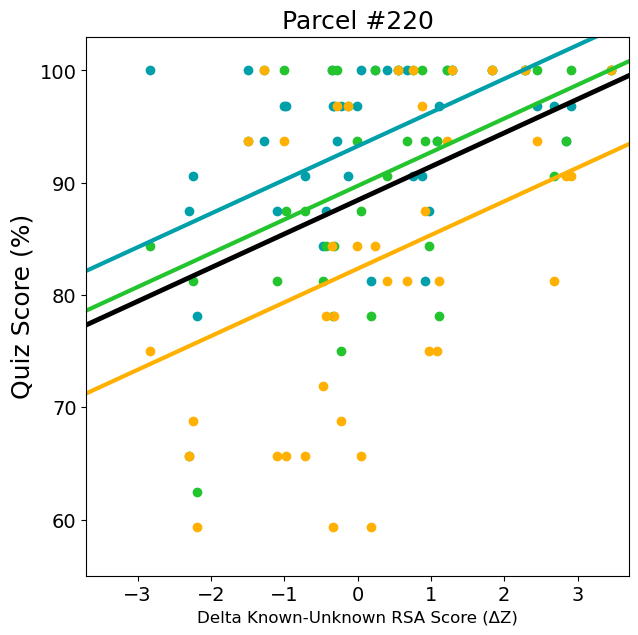

In [22]:
# Make LMER plot with intercepts for each predictor
score_type = 'Delta Known-Unknown RSA Score (ΔZ)'
out_dir = base_dir+'figures/'

slope = model.fixef[0]['neuralscore'].iloc[0]
intercept = np.mean(model.fixef[0]['(Intercept)'])

i_t1 = intercept + model.ranef[1].loc['T1quiz'].iloc[0]
i_t2 = intercept + model.ranef[1].loc['T2quiz'].iloc[0]
i_t3 = intercept + model.ranef[1].loc['T3quiz'].iloc[0]

# Create a figure and axis for the plots
plt.figure(figsize=(7, 7))

# Plot the scatter plots
plt.scatter(scores['neuralscore'], scores['T1quiz'], color='#00a0aa', label='Quiz1', alpha=1)
plt.scatter(scores['neuralscore'], scores['T2quiz'], color='#24c42e', label='Quiz2', alpha=1)
plt.scatter(scores['neuralscore'], scores['T3quiz'], color='#FFB000', label='Quiz3', alpha=1)

# Plot the lines
x_line = np.arange(-5, 5)  # X values for the lines

plt.plot(x_line,list(slope*x_line + intercept),linewidth=3.5,color='black')

plt.plot(x_line,list(slope*x_line + i_t1),color='#00a0aa',linewidth=3)
plt.plot(x_line,list(slope*x_line + i_t2),color='#24c42e',linewidth=3)
plt.plot(x_line,list(slope*x_line + i_t3),color='#FFB000',linewidth=3)


plt.title('Parcel #'+str(p+1),fontsize=18)
plt.xlabel(score_type,fontsize=12)
plt.ylabel('Quiz Score (%)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(55,103)
plt.xlim(-3.7,3.7)

out_fn = out_dir+'lmer_quizscores_parcID'+str(p)
plt.savefig(out_fn+'.png',transparent=True,dpi=300,bbox_inches="tight")

In [ ]:
# Permutation test is not ideal for running in a notebook like this
# See LMER_delta_score.py in Study 2/scripts for details on how this procedure was run.
# But essentially the same LMER model is fit 1,000 times, each time shuffling the mapping of neural score to behavioral scores.

In [32]:
# Once all permutation-tested models have been run, check for significant prediction
# For a two-tailed test, the appropriate Z threshold is 1.95

sig_parcs = union #all parcels from ASL or English maps

betaList=[]
zList=[]

predict_parcs = []
predict_Zs = []

for parc in sig_parcs:
    try:
        data = pickle.load(open(lmer_dir+'lmer_parcID-'+str(parc)+'_grp-all_rsa_delta-known-unknown_score_prediction.pkl','rb'))
        betaList.append(data['beta_obs'])
        zList.append(data['beta_Z'])
        if data['beta_Z'] >= 1.95:
            print("ParcID "+str(parc)+" predicts quiz scores with Z="+str(data['beta_Z'])+": "+str(data['beta_obs']))
            predict_parcs.append(parc)
            predict_Zs.append(data['beta_Z'])
        elif data['beta_Z'] <= -1.95:
            print("ParcID "+str(parc)+" is negatively associated with quiz scores, Z="+str(data['beta_Z']))
            predict_parcs.append(parc)
            predict_Zs.append(data['beta_Z'])

    except:
        print("no file for p#"+str(parc))
        continue

ParcID 32 predicts quiz scores with Z=2.022251988207931: 1.717
ParcID 147 predicts quiz scores with Z=2.088881019949206: 2.02
ParcID 219 predicts quiz scores with Z=2.0940393105197543: 1.999
ParcID 280 predicts quiz scores with Z=2.1231072341521933: 1.609
ParcID 455 predicts quiz scores with Z=2.123980227159225: 2.006


## Plot all these values in a heatmap on the FSAverage Surface

In [36]:
# Plot all these values in a heatmap on the FSAverage Surface

%run '/dartfs-hpc/rc/lab/K/KraemerD/ASL1-2_combined/scripts/asl_combo_functions_surface_plotting.py'

parc_vals = [0]*n_parcs

for p in range(len(sig_parcs)):
    parc_vals[sig_parcs[p]] = zList[p]

In [ ]:
rh_masked, lh_masked = parc_list_to_surf(parc_vals, 500)

fn = base_dir+'figures/LMER_grp-all_rsa_delta-known_unknown_predicting_quiz_z195'
four_panel_surfplot(rh_masked, lh_masked,fn,cmap_method='custom',custom_vmax=2,custom_vmin=-2,colormap='coolwarm',bg_on_data=True,
                   title='Quiz Score predicting Delta RSA -- Permuted Z>1.95')

fn = base_dir+'figures/LMER_grp-all_rsa_delta-known_unknown_predicting_quiz_z195_dorsal_ventral'
dors_vent_surfplot(rh_masked, lh_masked,fn,title="Quiz Score predicting Delta RSA -- grp-all -- Permuted Z>1.95",
                   cmap_method='custom',custom_vmax=2,custom_vmin=-2,colormap='coolwarm',bg_on_data=True,)